In [1]:
import pandas as pd
import numpy as np 
from glob import glob
import cv2
from skimage import io 
from tqdm import tqdm
import seaborn as sns
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory, image
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D, InputLayer
from tensorflow.keras import layers
import tensorflow.keras.optimizers as Optimizer
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.layers import (
    Input, Dense, Conv2D, Flatten, Activation, 
    MaxPooling2D, AveragePooling2D, ZeroPadding2D, GlobalAveragePooling2D, GlobalMaxPooling2D, add
)
import pandas as pd
import numpy as np 
from glob import glob
import cv2
from skimage import io 
from tqdm import tqdm
import seaborn as sns
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory, image
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D, InputLayer
from tensorflow.keras import layers
import tensorflow.keras.optimizers as Optimizer
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping()
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.utils import plot_model

from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3
#from tensorflow.keras.applications.inception_v3 import preprocess_input

In [2]:
ground_truth_df = pd.read_csv("ISIC_2019_Training_GroundTruth.csv")
meta_data_df = pd.read_csv("ISIC_2019_Training_Metadata.csv")
ground_truth_df

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
25326,ISIC_0073247,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
25327,ISIC_0073248,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
25328,ISIC_0073249,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25329,ISIC_0073251,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# MobileNet Model 1- 7 Classes

In [4]:
CFG = dict(
        batch_size        =  32,     # 8; 16; 32; 64; bigger batch size => moemry allocation issue
        epochs            =  100,   # 5; 10; 20;
        verbose           =   1,    # 0; 1
        workers           =   4,    # 1; 2; 3

        optimizer         = 'adam', # 'SGD', 'RMSprop'

        RANDOM_STATE      =  123,   
    
        # Path to save a model
        path_model        = '../working/',

        # Images sizes
        img_size          = 224, 
        img_height        = 224, 
        img_width         = 224, 

        # Images augs
        ROTATION          = 180.0,
        ZOOM              =  10.0,
        ZOOM_RANGE        =  [0.9,1.1],
        HZOOM             =  10.0,
        WZOOM             =  10.0,
        HSHIFT            =  10.0,
        WSHIFT            =  10.0,
        SHEAR             =   5.0,
        HFLIP             = True,
        VFLIP             = True,

        # Postprocessing
        label_smooth_fac  =  0.00,  # 0.01; 0.05; 0.1; 0.2;     Label smoothing is used when the loss function is cross entropy, and the model applies the softmax function to the penultimate layer’s logit vectors z to compute its output probabilities p. 
)

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.3,
    rotation_range            = CFG['ROTATION'],
    zoom_range                = CFG['ZOOM_RANGE'],
    horizontal_flip           = CFG['HFLIP'],
    vertical_flip             = CFG['VFLIP'],
    height_shift_range        = CFG['HSHIFT'],
    width_shift_range         = CFG['WSHIFT'],
    shear_range               = CFG['SHEAR'],
    channel_shift_range       = 0.0,
    brightness_range          = None,
    fill_mode                 = 'nearest',                          
    )

valid_generator = ImageDataGenerator(rescale=1./255, validation_split=0.3)              # no aug for valid
test_generator  = ImageDataGenerator(rescale=1./255)                                    # no aug for test
# Train data
train_generator = train_datagen.flow_from_directory("Image_dir_3",
                                                    subset='training',                  # to read train/valid from same directory 
                                                    target_size=(CFG['img_size'], CFG['img_size']),
                                                    batch_size = CFG['batch_size'],
                                                    class_mode='categorical',
                                                    )

# Validation data
valid_generator = valid_generator.flow_from_directory("Image_dir_3",
                                                     subset='validation',               # to read train/valid from same directory 
                                                     target_size=(CFG['img_size'], CFG['img_size']),
                                                     batch_size = CFG['batch_size'],
                                                     class_mode='categorical'
                                                     ) 
# Test data
test_generator  = test_generator.flow_from_directory("Image_dir_3",
                                                     target_size=(CFG['img_size'], CFG['img_size']),
                                                     batch_size = 1,                    # using 1 to easily manage mapping between test_gen & pred
                                                     class_mode='categorical'
                                                     )

Found 8723 images belonging to 7 classes.
Found 3733 images belonging to 7 classes.
Found 12456 images belonging to 7 classes.


In [6]:
from sklearn.utils import class_weight
from collections import Counter
class_weights= class_weight.compute_class_weight(class_weight= "balanced",
                                    classes= np.unique(train_generator.classes),
                                    y=train_generator.classes)

unique_class_weights = np.unique(train_generator.classes)
class_weights_dict={unique_class_weights[i]: w for i,w in enumerate(class_weights)}

print('\nCLASS WEIGHTS: {}\n'.format(class_weights))
print(np.unique(train_generator.classes))
print(train_generator.classes)
print(unique_class_weights)
print(Counter(train_generator.classes).keys())   # equals to list(set(x))
print(Counter(train_generator.classes).values()) # counts the elements' frequency


CLASS WEIGHTS: [2.05295364 0.53551476 0.67835757 7.41751701 0.39360166 2.83214286
 7.00080257]

[0 1 2 3 4 5 6]
[0 0 0 ... 6 6 6]
[0 1 2 3 4 5 6]
dict_keys([0, 1, 2, 3, 4, 5, 6])
dict_values([607, 2327, 1837, 168, 3166, 440, 178])


In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications import mobilenet_v2

# note we exclude the final dense layers by setting include_top=False,
# and add new ones to train from scratch below
base_model = mobilenet_v2.MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3)) 
 
# Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False    

# Establish new fully connected block
x = base_model.output
x = Flatten()(x) # flatten from convolution tensor output 
x = Dense(100, activation='relu')(x) # number of layers and units are hyperparameters, as usual
x = Dense(50, activation='relu')(x)
predictions = Dense(7, activation='softmax')(x) # should match # of classes predicted

# define formal model object to train and compile it as usual
model = Model(inputs=base_model.input, outputs=predictions)

In [8]:
model.compile(
    optimizer = CFG['optimizer'],
    loss="categorical_crossentropy",
    metrics =["accuracy"])

In [10]:
#tf.function-decorated function tried to create variables on non-first call'. 
tf.config.run_functions_eagerly(True) # otherwise error

# https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint
cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = 10)
cb_checkpointer  = ModelCheckpoint(filepath = CFG['path_model']+'MobileNet2-{epoch:02d}-{val_loss:.2f}.hdf5',
                                   monitor  = 'val_loss', 
                                   verbose  = CFG['verbose'], 
                                   save_best_only=True, 
                                   mode='min'
                                  )

callbacks_list = [cb_checkpointer, cb_early_stopper]

history3 = model.fit(train_generator, 
                             epochs=CFG['epochs'], 
                             workers=CFG['workers'],
                             validation_data=valid_generator, 
                             callbacks = callbacks_list,
                             class_weight = class_weights_dict
                            ) #thisone

/Users/snizhanakurylyuk/opt/anaconda3/envs/metis/lib/python3.7/site-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/100
273/273 [==============================] - ETA: 0s - loss: 2.6824 - accuracy: 0.3289
Epoch 00001: val_loss improved from inf to 2.12682, saving model to ../working/MobileNet2-01-2.13.hdf5
273/273 [==============================] - 2207s 8s/step - loss: 2.6824 - accuracy: 0.3289 - val_loss: 2.1268 - val_accuracy: 0.3383
Epoch 2/100
273/273 [==============================] - ETA: 0s - loss: 1.5793 - accuracy: 0.4403
Epoch 00002: val_loss improved from 2.12682 to 2.02058, saving model to ../working/MobileNet2-02-2.02.hdf5
273/273 [==============================] - 2252s 8s/step - loss: 1.5793 - accuracy: 0.4403 - val_loss: 2.0206 - val_accuracy: 0.3196
Epoch 3/100
273/273 [==============================] - ETA: 0s - loss: 1.4020 - accuracy: 0.4727
Epoch 00003: val_loss did not improve from 2.02058
273/273 [==============================] - 2526s 9s/step - loss: 1.4020 - accuracy: 0.4727 - val_loss: 2.0780 - val_accuracy: 0.3153
Epoch 4/100
273/273 [============================

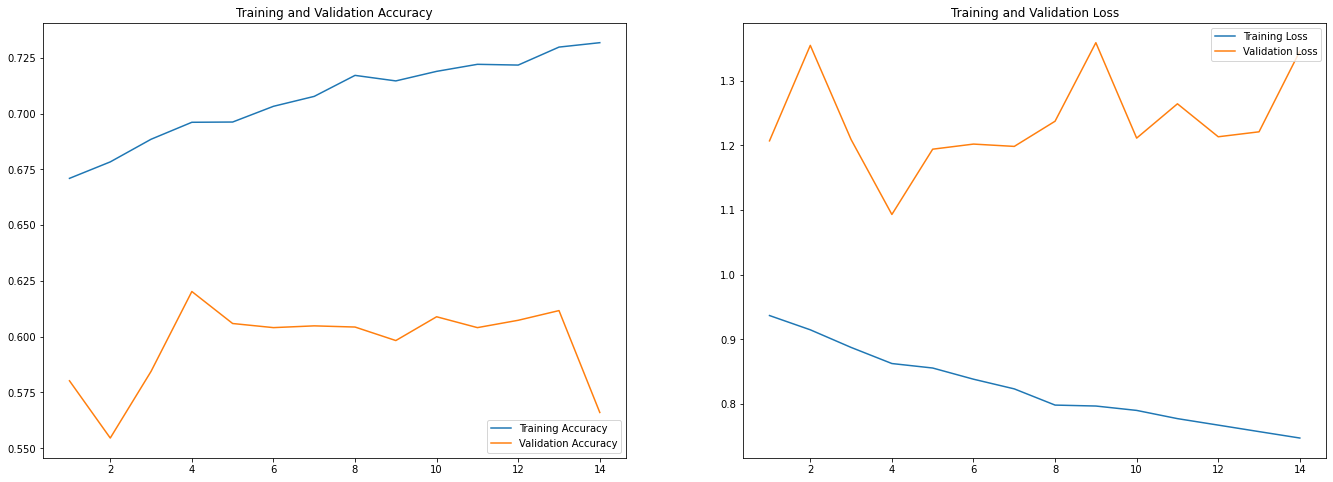

In [41]:
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

loss = history3.history['loss']
val_loss = history3.history['val_loss']

metrics = history3.history['accuracy']
epochs_range = range(1, len(metrics) + 1) 

plt.figure(figsize=(23, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [51]:
from sklearn.metrics import classification_report,confusion_matrix
predictions1=model.predict(valid_generator,steps=len(valid_generator))
y=np.argmax(predictions1,axis=1)

print('Classification Report')
cr=classification_report(y_true=valid_generator.classes,y_pred=y,target_names=valid_generator.class_indices)
print(cr)
evaluates=model.evaluate(valid_generator)
print(evaluates)

/Users/snizhanakurylyuk/opt/anaconda3/envs/metis/lib/python3.7/site-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Classification Report
              precision    recall  f1-score   support

   AK_images       0.00      0.00      0.00       260
  BCC_images       0.14      0.05      0.07       996
  BKL_images       0.11      0.33      0.17       787
   DF_images       0.00      0.00      0.00        71
  MEL_images       0.19      0.06      0.10      1356
   NV_images       0.51      0.56      0.53      3862
  SCC_images       0.00      0.00      0.00       188
 VASC_images       0.00      0.00      0.00        75

    accuracy                           0.34      7595
   macro avg       0.12      0.13      0.11      7595
weighted avg       0.32      0.34      0.32      7595



/Users/snizhanakurylyuk/opt/anaconda3/envs/metis/lib/python3.7/site-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


238/238 [==============================] - 568s 2s/step - loss: 1.3458 - accuracy: 0.5660
[1.345845341682434, 0.5660302639007568]


Confusion Matrix


<AxesSubplot:>

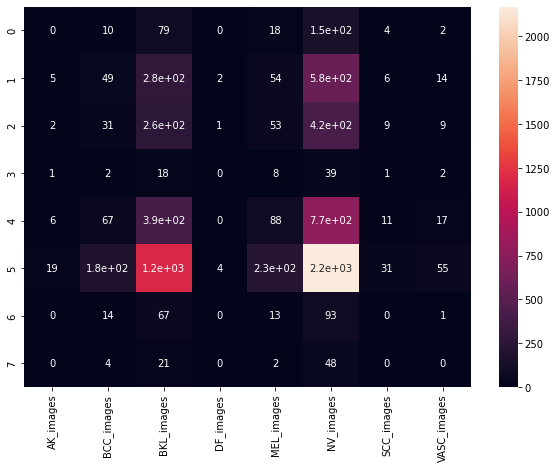

In [64]:
import pandas as pd
import numpy as np
import seaborn as sn
print('Confusion Matrix')
cm = confusion_matrix(valid_generator.classes,y)
df = pd.DataFrame(cm,columns=valid_generator.class_indices)
plt.figure(figsize=(10,7))
sn.heatmap(df,annot=True)

In [ ]:
tf.config.run_functions_eagerly(True) # otherwise error

# https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint
cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = 10)
cb_checkpointer  = ModelCheckpoint(filepath = CFG2['path_model']+'MobileNet2-{epoch:02d}-{val_loss:.2f}.hdf5',
                                   monitor  = 'val_loss', 
                                   verbose  = CFG2['verbose'], 
                                   save_best_only=True, 
                                   mode='min'
                                  )

callbacks_list = [cb_checkpointer, cb_early_stopper]

history3 = model.fit(train_generator, 
                             epochs=CFG2['epochs'], 
                             workers=CFG2['workers'],
                             validation_data=valid_generator, 
                             callbacks = callbacks_list,
                             class_weight = class_weights_dict
                            )

/Users/snizhanakurylyuk/opt/anaconda3/envs/metis/lib/python3.7/site-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/100
555/555 [==============================] - ETA: 0s - loss: 1.3825 - accuracy: 0.5813 
Epoch 00001: val_loss improved from inf to 1.35780, saving model to ../working/MobileNet2-01-1.36.hdf5
555/555 [==============================] - 6914s 12s/step - loss: 1.3825 - accuracy: 0.5813 - val_loss: 1.3578 - val_accuracy: 0.5430
Epoch 2/100
555/555 [==============================] - ETA: 0s - loss: 1.2214 - accuracy: 0.5983
Epoch 00002: val_loss did not improve from 1.35780
555/555 [==============================] - 4500s 8s/step - loss: 1.2214 - accuracy: 0.5983 - val_loss: 1.5301 - val_accuracy: 0.4907
Epoch 3/100
555/555 [==============================] - ETA: 0s - loss: 1.1495 - accuracy: 0.6058 
Epoch 00003: val_loss did not improve from 1.35780
555/555 [==============================] - 8361s 15s/step - loss: 1.1495 - accuracy: 0.6058 - val_loss: 1.7386 - val_accuracy: 0.4032
Epoch 4/100
555/555 [==============================] - ETA: 0s - loss: 1.1011 - accuracy: 0.6037
Epoc

In [ ]:
model.summary()


# Model Fine tuning 

In [38]:
CFG2 = dict(
        batch_size        =  32,     # 8; 16; 32; 64; bigger batch size => moemry allocation issue
        epochs            =  100,   # 5; 10; 20;
        verbose           =   1,    # 0; 1
        workers           =   4,    # 1; 2; 3

        optimizer         = 'adam', # 'SGD', 'RMSprop'

        RANDOM_STATE      =  123,   
    
        # Path to save a model
        path_model        = '../working/',

        # Images sizes
        img_size          = 224, 
        img_height        = 224, 
        img_width         = 224, 

        # Images augs
        ROTATION          = 10.0,
        ZOOM              =  10.0,
        ZOOM_RANGE        =  0.05,
        HZOOM             =  10.0,
        WZOOM             =  10.0,
        HSHIFT            =  0.01,
        WSHIFT            =  0.01,
        SHEAR             =  0.01,
        HFLIP             = True,
        VFLIP             = True,

        # Postprocessing
        label_smooth_fac  =  0.00,  # 0.01; 0.05; 0.1; 0.2;     Label smoothing is used when the loss function is cross entropy, and the model applies the softmax function to the penultimate layer’s logit vectors z to compute its output probabilities p. 
)

In [39]:
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.3,
    rotation_range            = CFG2['ROTATION'],
    zoom_range                = CFG2['ZOOM_RANGE'],
    horizontal_flip           = CFG2['HFLIP'],
    vertical_flip             = CFG2['VFLIP'],
    height_shift_range        = CFG2['HSHIFT'],
    width_shift_range         = CFG2['WSHIFT'],
    shear_range               = CFG2['SHEAR'],
    brightness_range          = (0.3, 1.0),
    fill_mode                 = 'nearest',                          
    )

valid_generator = ImageDataGenerator(rescale=1./255, validation_split=0.3)              # no aug for valid
test_generator  = ImageDataGenerator(rescale=1./255)                                    # no aug for test
# Train data
train_generator = train_datagen.flow_from_directory("Image_dir_3",
                                                    subset='training',                  # to read train/valid from same directory 
                                                    target_size=(CFG2['img_size'], CFG2['img_size']),
                                                    batch_size = CFG2['batch_size'],
                                                    color_mode="rgb",
                                                    shuffle=True,
                                                    class_mode='categorical',
                                                    )

# Validation data
valid_generator = valid_generator.flow_from_directory("Image_dir_3",
                                                     subset='validation',               # to read train/valid from same directory 
                                                     target_size=(CFG2['img_size'], CFG2['img_size']),
                                                     batch_size = CFG2['batch_size'],
                                                     color_mode="rgb",
                                                     shuffle=False,
                                                     class_mode='categorical'
                                                     ) 
# Test data
test_generator  = test_generator.flow_from_directory("Image_dir_3",
                                                     target_size=(CFG2['img_size'], CFG2['img_size']),
                                                     batch_size = 1, 
                                                     color_mode="rgb",                  # using 1 to easily manage mapping between test_gen & pred
                                                     class_mode="categorical",
                                                     shuffle=False,
                                                     )

Found 5557 images belonging to 6 classes.
Found 2377 images belonging to 6 classes.
Found 7934 images belonging to 6 classes.


In [34]:
from sklearn.utils import class_weight
from collections import Counter
class_weights= class_weight.compute_class_weight(class_weight= "balanced",
                                    classes= np.unique(train_generator.classes),
                                    y=train_generator.classes)

unique_class_weights = np.unique(train_generator.classes)
class_weights_dict={unique_class_weights[i]: w for i,w in enumerate(class_weights)}

print('\nCLASS WEIGHTS: {}\n'.format(class_weights))
print(np.unique(train_generator.classes))
print(train_generator.classes)
print(unique_class_weights)
print(Counter(train_generator.classes).keys())   # equals to list(set(x))
print(Counter(train_generator.classes).values()) # counts the elements' frequency


CLASS WEIGHTS: [1.52580999 0.39800888 0.50417347 5.51289683 2.10492424 5.20318352]

[0 1 2 3 4 5]
[0 0 0 ... 5 5 5]
[0 1 2 3 4 5]
dict_keys([0, 1, 2, 3, 4, 5])
dict_values([607, 2327, 1837, 168, 440, 178])


In [40]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications import mobilenet_v2

# note we exclude the final dense layers by setting include_top=False,
# and add new ones to train from scratch below
base_model = mobilenet_v2.MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224
                                                                                          ,3)) 
 
# Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False    

# Establish new fully connected block
x = base_model.output
x = Flatten()(x) # flatten from convolution tensor output 
x = Dense(100, activation='relu')(x) # number of layers and units are hyperparameters, as usual
x = Dense(50, activation='relu')(x)
predictions = Dense(6, activation='softmax')(x) # should match # of classes predicted

# define formal model object to train and compile it as usual
model2 = Model(inputs=base_model.input, outputs=predictions)

In [41]:
model2.compile(
    optimizer = CFG2['optimizer'],
    loss="categorical_crossentropy",
    metrics =["accuracy"])

In [42]:
tf.config.run_functions_eagerly(True) # otherwise error

# https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint
cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = 10)
cb_checkpointer  = ModelCheckpoint(filepath = CFG2['path_model']+'MobileNet3-{epoch:02d}-{val_loss:.2f}.hdf5',
                                   monitor  = 'val_loss', 
                                   verbose  = CFG2['verbose'], 
                                   save_best_only=True, 
                                   mode='min'
                                  )

callbacks_list = [cb_checkpointer, cb_early_stopper]

history3 = model2.fit(train_generator, 
                             epochs=CFG2['epochs'], 
                             workers=CFG2['workers'],
                             validation_data=valid_generator, 
                             callbacks = callbacks_list,
                             class_weight = class_weights_dict
                            )

Epoch 1/100
174/174 [==============================] - ETA: 0s - loss: 2.9991 - accuracy: 0.3075
Epoch 00001: val_loss improved from inf to 2.17357, saving model to ../working/MobileNet3-01-2.17.hdf5
174/174 [==============================] - 1556s 9s/step - loss: 2.9991 - accuracy: 0.3075 - val_loss: 2.1736 - val_accuracy: 0.2171
Epoch 2/100
174/174 [==============================] - ETA: 0s - loss: 1.4361 - accuracy: 0.3577
Epoch 00002: val_loss improved from 2.17357 to 1.39419, saving model to ../working/MobileNet3-02-1.39.hdf5
174/174 [==============================] - 1602s 9s/step - loss: 1.4361 - accuracy: 0.3577 - val_loss: 1.3942 - val_accuracy: 0.4485
Epoch 3/100
174/174 [==============================] - ETA: 0s - loss: 1.2914 - accuracy: 0.4188
Epoch 00003: val_loss did not improve from 1.39419
174/174 [==============================] - 1821s 10s/step - loss: 1.2914 - accuracy: 0.4188 - val_loss: 1.6815 - val_accuracy: 0.4283
Epoch 4/100
174/174 [===========================

# MobileNet Model 2- 4 classes

In [54]:
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.3,
    rotation_range            = CFG2['ROTATION'],
    zoom_range                = CFG2['ZOOM_RANGE'],
    horizontal_flip           = CFG2['HFLIP'],
    vertical_flip             = CFG2['VFLIP'],
    height_shift_range        = CFG2['HSHIFT'],
    width_shift_range         = CFG2['WSHIFT'],
    shear_range               = CFG2['SHEAR'],
    brightness_range          = (0.3, 1.0),
    fill_mode                 = 'nearest',                          
    )

valid_generator = ImageDataGenerator(rescale=1./255, validation_split=0.3)              # no aug for valid
test_generator  = ImageDataGenerator(rescale=1./255)                                    # no aug for test
# Train data
train_generator2 = train_datagen.flow_from_directory("Image_dir_4",
                                                    subset='training',                  # to read train/valid from same directory 
                                                    target_size=(CFG2['img_size'], CFG2['img_size']),
                                                    batch_size = CFG2['batch_size'],
                                                    color_mode="rgb",
                                                    shuffle=True,
                                                    class_mode='categorical',
                                                    )

# Validation data
valid_generator2 = valid_generator.flow_from_directory("Image_dir_4",
                                                     subset='validation',               # to read train/valid from same directory 
                                                     target_size=(CFG2['img_size'], CFG2['img_size']),
                                                     batch_size = CFG2['batch_size'],
                                                     color_mode="rgb",
                                                     shuffle=False,
                                                     class_mode='categorical'
                                                     ) 
# Test data
test_generator2  = test_generator.flow_from_directory("Image_dir_4",
                                                     target_size=(CFG2['img_size'], CFG2['img_size']),
                                                     batch_size = 1, 
                                                     color_mode="rgb",                  # using 1 to easily manage mapping between test_gen & pred
                                                     class_mode="categorical",
                                                     shuffle=False,
                                                     )

Found 4510 images belonging to 4 classes.
Found 1929 images belonging to 4 classes.
Found 6439 images belonging to 4 classes.


In [46]:
from sklearn.utils import class_weight
from collections import Counter
class_weights= class_weight.compute_class_weight(class_weight= "balanced",
                                    classes= np.unique(train_generator2.classes),
                                    y=train_generator2.classes)

unique_class_weights = np.unique(train_generator2.classes)
class_weights_dict={unique_class_weights[i]: w for i,w in enumerate(class_weights)}

print('\nCLASS WEIGHTS: {}\n'.format(class_weights))
print(np.unique(train_generator2.classes))
print(train_generator2.classes)
print(unique_class_weights)
print(Counter(train_generator2.classes).keys())   # equals to list(set(x))
print(Counter(train_generator2.classes).values()) # counts the elements' frequency


CLASS WEIGHTS: [0.48452944 0.61377246 6.71130952 6.33426966]

[0 1 2 3]
[0 0 0 ... 3 3 3]
[0 1 2 3]
dict_keys([0, 1, 2, 3])
dict_values([2327, 1837, 168, 178])


In [47]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications import mobilenet_v2

# note we exclude the final dense layers by setting include_top=False,
# and add new ones to train from scratch below
base_model = mobilenet_v2.MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224
                                                                                          ,3)) 
 
# Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False    

# Establish new fully connected block
x = base_model.output
x = Flatten()(x) # flatten from convolution tensor output 
x = Dense(100, activation='relu')(x) # number of layers and units are hyperparameters, as usual
x = Dense(50, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x) # should match # of classes predicted

# define formal model object to train and compile it as usual
final_model_4 = Model(inputs=base_model.input, outputs=predictions)

In [48]:
final_model_4.compile(
    optimizer = CFG2['optimizer'],
    loss="categorical_crossentropy",
    metrics =["accuracy"])

In [49]:
tf.config.run_functions_eagerly(True) # otherwise error

# https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint
cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = 10)
cb_checkpointer  = ModelCheckpoint(filepath = CFG2['path_model']+'MobileNet3_finalmodel-{epoch:02d}-{val_loss:.2f}.hdf5',
                                   monitor  = 'val_loss', 
                                   verbose  = CFG2['verbose'], 
                                   save_best_only=True, 
                                   mode='min'
                                  )

callbacks_list = [cb_checkpointer, cb_early_stopper]

history3 = final_model_4.fit(train_generator2, 
                             epochs=CFG2['epochs'], 
                             workers=CFG2['workers'],
                             validation_data=valid_generator2, 
                             callbacks = callbacks_list,
                             class_weight = class_weights_dict
                            )

Epoch 1/100
141/141 [==============================] - ETA: 0s - loss: 2.2914 - accuracy: 0.4248
Epoch 00001: val_loss improved from inf to 1.17218, saving model to ../working/MobileNet3_finalmodel-01-1.17.hdf5
141/141 [==============================] - 799s 6s/step - loss: 2.2914 - accuracy: 0.4248 - val_loss: 1.1722 - val_accuracy: 0.5205
Epoch 2/100
141/141 [==============================] - ETA: 0s - loss: 1.0346 - accuracy: 0.5317
Epoch 00002: val_loss improved from 1.17218 to 1.14145, saving model to ../working/MobileNet3_finalmodel-02-1.14.hdf5
141/141 [==============================] - 816s 6s/step - loss: 1.0346 - accuracy: 0.5317 - val_loss: 1.1415 - val_accuracy: 0.5619
Epoch 3/100
141/141 [==============================] - ETA: 0s - loss: 0.9067 - accuracy: 0.5665
Epoch 00003: val_loss improved from 1.14145 to 0.99969, saving model to ../working/MobileNet3_finalmodel-03-1.00.hdf5
141/141 [==============================] - 779s 6s/step - loss: 0.9067 - accuracy: 0.5665 - val

In [51]:
from sklearn.metrics import classification_report,confusion_matrix
predictions1=final_model_4.predict(valid_generator2,steps=len(valid_generator2))
y=np.argmax(predictions1,axis=1)

print('Classification Report')
cr=classification_report(y_true=valid_generator2.classes,y_pred=y,target_names=valid_generator2.class_indices)
print(cr)
evaluates=final_model_4.evaluate(valid_generator2)
print(evaluates)

Classification Report
              precision    recall  f1-score   support

  BCC_images       0.90      0.41      0.56       996
  BKL_images       0.70      0.61      0.65       787
   DF_images       0.11      0.79      0.19        71
 VASC_images       0.24      0.84      0.37        75

    accuracy                           0.52      1929
   macro avg       0.48      0.66      0.44      1929
weighted avg       0.76      0.52      0.58      1929



/Users/snizhanakurylyuk/opt/anaconda3/envs/metis/lib/python3.7/site-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


61/61 [==============================] - 79s 1s/step - loss: 1.7266 - accuracy: 0.5215
[1.7265933752059937, 0.5215137600898743]


# MobileNet Model 3- 3 Classes

In [53]:
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.3,
    rotation_range            = CFG2['ROTATION'],
    zoom_range                = CFG2['ZOOM_RANGE'],
    horizontal_flip           = CFG2['HFLIP'],
    vertical_flip             = CFG2['VFLIP'],
    height_shift_range        = CFG2['HSHIFT'],
    width_shift_range         = CFG2['WSHIFT'],
    shear_range               = CFG2['SHEAR'],
    brightness_range          = (0.3, 1.0),
    fill_mode                 = 'nearest',                          
    )

valid_generator = ImageDataGenerator(rescale=1./255, validation_split=0.3)              # no aug for valid
test_generator  = ImageDataGenerator(rescale=1./255)                                    # no aug for test
# Train data
train_generator3 = train_datagen.flow_from_directory("Image_dir_5",
                                                    subset='training',                  # to read train/valid from same directory 
                                                    target_size=(CFG2['img_size'], CFG2['img_size']),
                                                    batch_size = CFG2['batch_size'],
                                                    color_mode="rgb",
                                                    shuffle=True,
                                                    class_mode='categorical',
                                                    )

# Validation data
valid_generator3 = valid_generator.flow_from_directory("Image_dir_5",
                                                     subset='validation',               # to read train/valid from same directory 
                                                     target_size=(CFG2['img_size'], CFG2['img_size']),
                                                     batch_size = CFG2['batch_size'],
                                                     color_mode="rgb",
                                                     shuffle=False,
                                                     class_mode='categorical'
                                                     ) 
# Test data
test_generator3  = test_generator.flow_from_directory("Image_dir_5",
                                                     target_size=(CFG2['img_size'], CFG2['img_size']),
                                                     batch_size = 1, 
                                                     color_mode="rgb",                  # using 1 to easily manage mapping between test_gen & pred
                                                     class_mode="categorical",
                                                     shuffle=False,
                                                     )

Found 4342 images belonging to 3 classes.
Found 1858 images belonging to 3 classes.
Found 6200 images belonging to 3 classes.


In [55]:
from sklearn.utils import class_weight
from collections import Counter
class_weights= class_weight.compute_class_weight(class_weight= "balanced",
                                    classes= np.unique(train_generator3.classes),
                                    y=train_generator3.classes)

unique_class_weights = np.unique(train_generator2.classes)
class_weights_dict={unique_class_weights[i]: w for i,w in enumerate(class_weights)}

print('\nCLASS WEIGHTS: {}\n'.format(class_weights))
print(np.unique(train_generator3.classes))
print(train_generator3.classes)
print(unique_class_weights)
print(Counter(train_generator3.classes).keys())   # equals to list(set(x))
print(Counter(train_generator3.classes).values()) # counts the elements' frequency


CLASS WEIGHTS: [0.62197393 0.78787879 8.13108614]

[0 1 2]
[0 0 0 ... 2 2 2]
[0 1 2 3]
dict_keys([0, 1, 2])
dict_values([2327, 1837, 178])


In [56]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications import mobilenet_v2

# note we exclude the final dense layers by setting include_top=False,
# and add new ones to train from scratch below
base_model = mobilenet_v2.MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224
                                                                                          ,3)) 
 
# Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False    

# Establish new fully connected block
x = base_model.output
x = Flatten()(x) # flatten from convolution tensor output 
x = Dense(100, activation='relu')(x) # number of layers and units are hyperparameters, as usual
x = Dense(50, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x) # should match # of classes predicted

# define formal model object to train and compile it as usual
final_model_5 = Model(inputs=base_model.input, outputs=predictions)

In [57]:
final_model_5.compile(
    optimizer = CFG2['optimizer'],
    loss="categorical_crossentropy",
    metrics =["accuracy"])

In [58]:
tf.config.run_functions_eagerly(True) # otherwise error

# https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint
cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = 15)
cb_checkpointer  = ModelCheckpoint(filepath = CFG2['path_model']+'MobileNet3_finalmodel5-{epoch:02d}-{val_loss:.2f}.hdf5',
                                   monitor  = 'val_loss', 
                                   verbose  = CFG2['verbose'], 
                                   save_best_only=True, 
                                   mode='min'
                                  )

callbacks_list = [cb_checkpointer, cb_early_stopper]

history3 = final_model_5.fit(train_generator3, 
                             epochs=CFG2['epochs'], 
                             workers=CFG2['workers'],
                             validation_data=valid_generator3, 
                             callbacks = callbacks_list,
                             class_weight = class_weights_dict
                            )

Epoch 1/100
136/136 [==============================] - ETA: 0s - loss: 1.9658 - accuracy: 0.5772
Epoch 00001: val_loss improved from inf to 1.03687, saving model to ../working/MobileNet3_finalmodel5-01-1.04.hdf5
136/136 [==============================] - 666s 5s/step - loss: 1.9658 - accuracy: 0.5772 - val_loss: 1.0369 - val_accuracy: 0.6712
Epoch 2/100
136/136 [==============================] - ETA: 0s - loss: 0.8758 - accuracy: 0.6918
Epoch 00002: val_loss improved from 1.03687 to 0.86824, saving model to ../working/MobileNet3_finalmodel5-02-0.87.hdf5
136/136 [==============================] - 973s 7s/step - loss: 0.8758 - accuracy: 0.6918 - val_loss: 0.8682 - val_accuracy: 0.7223
Epoch 3/100
136/136 [==============================] - ETA: 0s - loss: 0.5756 - accuracy: 0.7345
Epoch 00003: val_loss improved from 0.86824 to 0.86724, saving model to ../working/MobileNet3_finalmodel5-03-0.87.hdf5
136/136 [==============================] - 1039s 8s/step - loss: 0.5756 - accuracy: 0.7345 -

Epoch 29/100
136/136 [==============================] - ETA: 0s - loss: 0.2071 - accuracy: 0.8950
Epoch 00029: val_loss did not improve from 0.68582
136/136 [==============================] - 871s 6s/step - loss: 0.2071 - accuracy: 0.8950 - val_loss: 0.7984 - val_accuracy: 0.7729
Epoch 30/100
136/136 [==============================] - ETA: 0s - loss: 0.2442 - accuracy: 0.8791
Epoch 00030: val_loss did not improve from 0.68582
136/136 [==============================] - 873s 6s/step - loss: 0.2442 - accuracy: 0.8791 - val_loss: 0.8210 - val_accuracy: 0.7513
Epoch 31/100
136/136 [==============================] - ETA: 0s - loss: 0.2448 - accuracy: 0.8848
Epoch 00031: val_loss did not improve from 0.68582
136/136 [==============================] - 891s 7s/step - loss: 0.2448 - accuracy: 0.8848 - val_loss: 1.2405 - val_accuracy: 0.6981
Epoch 32/100
136/136 [==============================] - ETA: 0s - loss: 0.2143 - accuracy: 0.8924
Epoch 00032: val_loss did not improve from 0.68582
136/136 

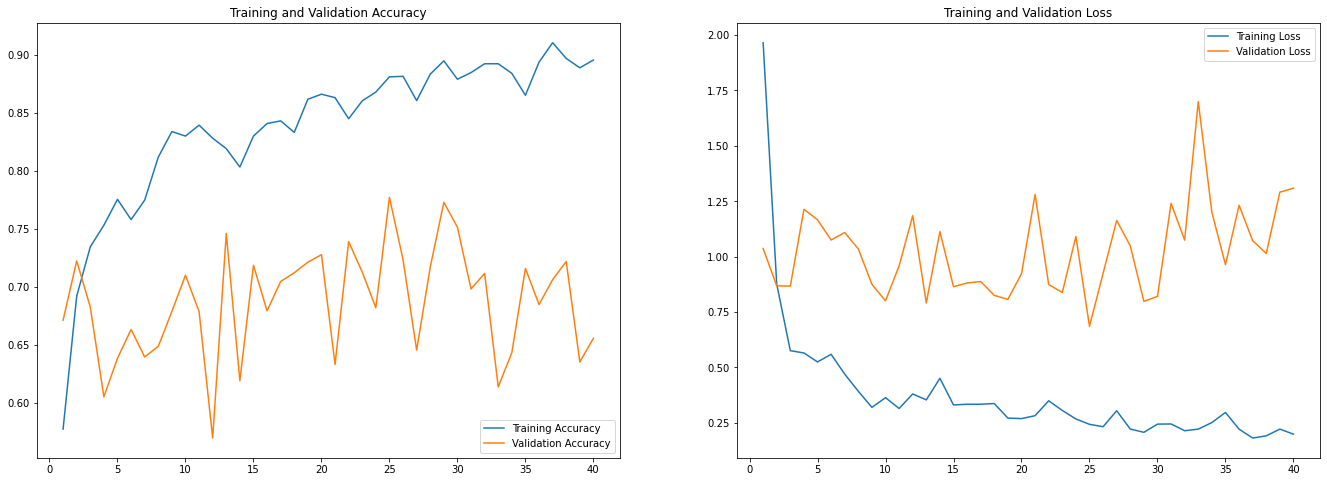

In [59]:
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

loss = history3.history['loss']
val_loss = history3.history['val_loss']

metrics = history3.history['accuracy']
epochs_range = range(1, len(metrics) + 1) 

plt.figure(figsize=(23, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [61]:
from sklearn.metrics import classification_report,confusion_matrix
predictions1=final_model_5.predict(valid_generator3,steps=len(valid_generator3))
y=np.argmax(predictions1,axis=1)

print('Classification Report')
cr=classification_report(y_true=valid_generator3.classes,y_pred=y,target_names=valid_generator3.class_indices)
print(cr)
evaluates=final_model_5.evaluate(valid_generator3)
print(evaluates)

/Users/snizhanakurylyuk/opt/anaconda3/envs/metis/lib/python3.7/site-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Classification Report
              precision    recall  f1-score   support

  BCC_images       0.90      0.42      0.58       996
  BKL_images       0.57      0.94      0.71       787
 VASC_images       0.65      0.71      0.68        75

    accuracy                           0.66      1858
   macro avg       0.71      0.69      0.66      1858
weighted avg       0.75      0.66      0.64      1858



/Users/snizhanakurylyuk/opt/anaconda3/envs/metis/lib/python3.7/site-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


59/59 [==============================] - 53s 898ms/step - loss: 1.3088 - accuracy: 0.6555
[1.3088324069976807, 0.6555435657501221]


Confusion Matrix


<AxesSubplot:>

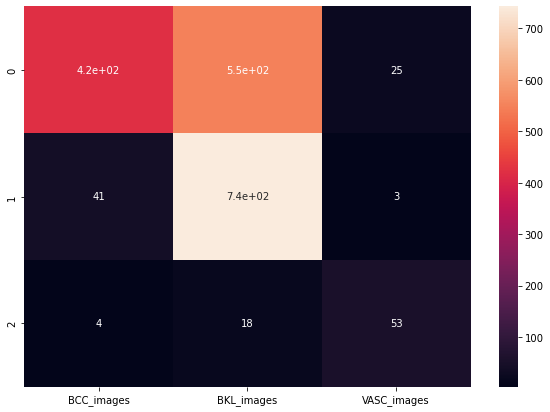

In [63]:
import pandas as pd
import numpy as np
import seaborn as sn
print('Confusion Matrix')
cm = confusion_matrix(valid_generator3.classes,y)
df = pd.DataFrame(cm,columns=valid_generator3.class_indices)
plt.figure(figsize=(10,7))
sn.heatmap(df,annot=True)

In [66]:
y_pred = final_model_5.predict(test_generator3)
y_pred

/Users/snizhanakurylyuk/opt/anaconda3/envs/metis/lib/python3.7/site-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


array([[2.6089576e-01, 7.3903096e-01, 7.3330768e-05],
       [1.2375755e-03, 9.9876249e-01, 1.8562788e-11],
       [5.6185007e-01, 3.6271253e-01, 7.5437412e-02],
       ...,
       [1.4112941e-04, 6.3413812e-09, 9.9985886e-01],
       [1.3838683e-02, 2.3689143e-02, 9.6247214e-01],
       [7.2048228e-11, 7.3903821e-11, 1.0000000e+00]], dtype=float32)

In [74]:
from tensorflow.keras.utils import to_categorical

Y_test = to_categorical(test_generator3.classes)  # hot encoded GT
